In [29]:
import sys
sys.path.append(r"/mnt/ceph/users/tudomlumleart/00_VirtualEnvironments/teeu/lib/python3.10/site-packages")
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")
sys.path.append(r"/mnt/home/tudomlumleart/ceph/00_VirtualEnvironments/jupyter-gpu/lib/python3.10/site-packages")
from utils import *
from functions import *
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture 
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import validation_curve

os.environ['TF_ENABLE_ONEDNN_OPTS']='0'

from sklearn.metrics import adjusted_mutual_info_score

import os
import scipy.io

In [30]:
# Load dataset from file
folder_path = '/mnt/home/tudomlumleart/ceph/05_Sox9Dataset/'

# List all .mat files in the folder and load them
cnc_maps = scipy.io.loadmat(folder_path + 'cncMaps.mat')['cncMaps'][:80, :80, :]
esc_maps = scipy.io.loadmat(folder_path + 'escMaps.mat')['escMaps'][:80, :80, :]

# Load polys data and then perform linear interpolation
# List all .mat files in the folder and load them
cnc_polys = scipy.io.loadmat(folder_path + 'cncPols.mat')['cncPols'][:80, :, :]
esc_polys = scipy.io.loadmat(folder_path + 'escPols.mat')['escPols'][:80, :, :]


In [31]:
def interpolate_polymers(polys):
    num_probes, num_coords, num_cells = polys.shape
    new_polys = np.zeros((num_probes, num_coords, num_cells))
    for c in range(num_cells):
        curr_cells = polys[:, :, c]
        for x in range(num_coords):
            curr_coords = curr_cells[:, x]
            missing_indices = np.isnan(curr_coords)
            valid_indices = ~missing_indices
            interp_coords = np.interp(np.flatnonzero(missing_indices), np.flatnonzero(valid_indices), curr_coords[valid_indices])
            new_polys[missing_indices, x, c] = interp_coords
            new_polys[valid_indices, x, c] = curr_coords[valid_indices]
    return new_polys

In [32]:
esc_polys_interp = interpolate_polymers(esc_polys)
cnc_polys_interp = interpolate_polymers(cnc_polys)

esc_maps_interp = np.array([squareform(pdist(esc_polys_interp[:, :, i])) for i in range(esc_polys_interp.shape[2])])
cnc_maps_interp = np.array([squareform(pdist(cnc_polys_interp[:, :, i])) for i in range(cnc_polys_interp.shape[2])])
esc_maps_interp_flat = np.array([x.flatten() for x in esc_maps_interp])
cnc_maps_interp_flat = np.array([x.flatten() for x in cnc_maps_interp])
all_maps_interp_flat = np.concatenate((esc_maps_interp_flat, cnc_maps_interp_flat), axis=0)

In [33]:
esc_median_map = np.median(esc_maps_interp, axis=0)
cnc_median_map = np.median(cnc_maps_interp, axis=0)

In [34]:
all_maps_interp_flat.shape

(2982, 6400)

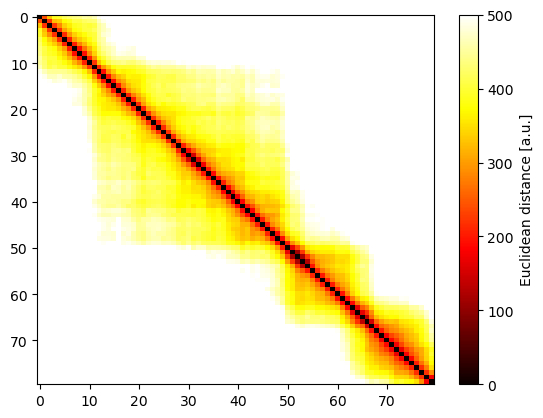

In [35]:
visualize_dmap(esc_median_map, vmax=500)

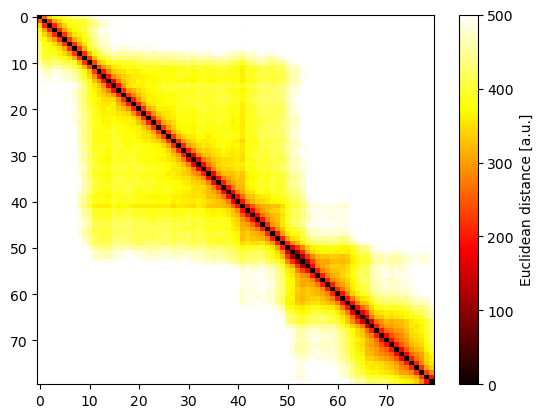

In [36]:
visualize_dmap(cnc_median_map, vmax=500)

In [37]:
def calculate_variance_sample(dmap_list):
    median_map = np.median(dmap_list, axis=0)
    variance_list = [np.linalg.norm(x - median_map) for x in dmap_list]
    return np.mean(variance_list)

In [38]:
var_esc = calculate_variance_sample(esc_maps_interp)
var_cnc = calculate_variance_sample(cnc_maps_interp)

In [39]:
var_esc

22969.742750602334

In [40]:
var_cnc

22337.517327335514

In [41]:
templates_flatten = np.vstack([esc_median_map.flatten(), cnc_median_map.flatten()])
num_monomers = 80
measurement_error = [var_esc**0.5, var_cnc**0.5]

In [42]:
 # Generate log prior for metastructures 
lpm = [(logprior(x, num_monomers)).tolist() for x in templates_flatten]

In [43]:
# Generate log likelihood for observations given metastructures 
ll_esc = [[(loglikelihood(y, x, z, num_monomers)).tolist() for x, z in zip(templates_flatten, measurement_error)] for y in esc_maps_interp_flat]
ll_cnc = [[(loglikelihood(y, x, z, num_monomers)).tolist() for x, z in zip(templates_flatten, measurement_error)] for y in cnc_maps_interp_flat]

In [64]:
def load_weights(directory, num_metastructures):
    log_weights = []
    lp = []
    files = sorted(os.listdir(directory))[-4:]
    print(files)
    
    log_weights_d = []
    for file in files:
        log_weights_chain = []
        lp_chain = []
        with open('%s/%s'%(directory, file), newline='') as csvfile:
            reader = csv.DictReader(filter(lambda row: row[0]!='#', csvfile), )
            for row in reader:
                log_weights_row = [float(row["log_weights.%d"%i]) for i in range(1,num_metastructures+1)]
                lp_chain.append(float(row["lp__"]))
                log_weights_chain.append(log_weights_row)
        log_weights = np.array(log_weights_chain)
        lp_chain = np.array(lp_chain)
        log_weights_d.append(log_weights)
        lp.append(lp_chain)
    log_weights_d = np.array(log_weights_d)
    return log_weights_d 


In [87]:
stan_directory_esc = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/20240731_MCMC_2med_diff_var/ESC/stan_output'
stan_directory_cnc = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/20240731_MCMC_2med_diff_var/CNC/stan_output'
stan_directory_all = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/20240731_MCMC_2med_diff_var/all/stan_output'


In [88]:
esc_log_weights = load_weights(stan_directory_esc, 2)
cnc_log_weights = load_weights(stan_directory_cnc, 2)
all_log_weights = load_weights(stan_directory_all, 2)

['20240715_WeightOptimization-20240801101315_1.csv', '20240715_WeightOptimization-20240801101315_2.csv', '20240715_WeightOptimization-20240801101315_3.csv', '20240715_WeightOptimization-20240801101315_4.csv']
['20240715_WeightOptimization-20240801101318_1.csv', '20240715_WeightOptimization-20240801101318_2.csv', '20240715_WeightOptimization-20240801101318_3.csv', '20240715_WeightOptimization-20240801101318_4.csv']
['20240715_WeightOptimization-20240801101322_1.csv', '20240715_WeightOptimization-20240801101322_2.csv', '20240715_WeightOptimization-20240801101322_3.csv', '20240715_WeightOptimization-20240801101322_4.csv']


In [60]:
import corner

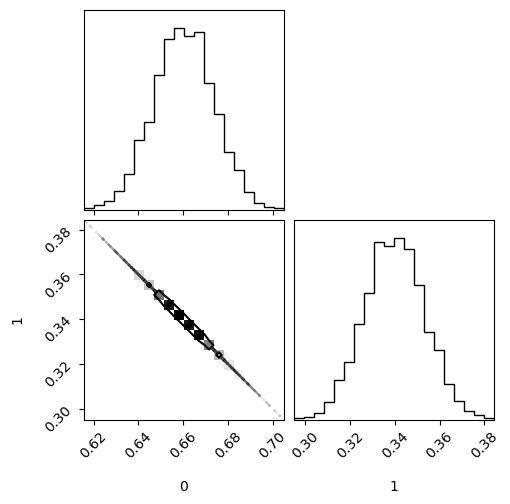

In [89]:
log_weights_d = np.array(esc_log_weights)
log_weights_d_flat = log_weights_d.reshape(-1, 2)
corner.corner(np.exp(log_weights_d_flat), labels=[str(i) for i in range(2)])
plt.savefig(stan_directory_esc + 'corner_esc.png')

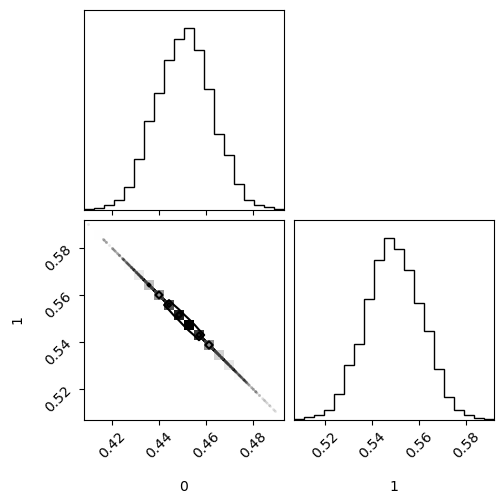

In [90]:
log_weights_d = np.array(cnc_log_weights)
log_weights_d_flat = log_weights_d.reshape(-1, 2)
corner.corner(np.exp(log_weights_d_flat), labels=[str(i) for i in range(2)])
plt.savefig(stan_directory_cnc + 'corner_cnc.png')

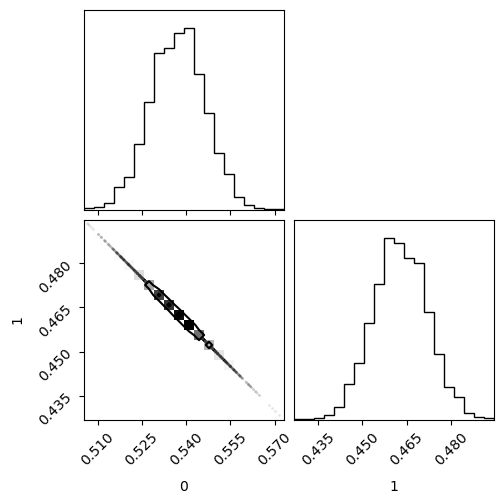

In [91]:
log_weights_d = np.array(all_log_weights)
log_weights_d_flat = log_weights_d.reshape(-1, 2)
corner.corner(np.exp(log_weights_d_flat), labels=[str(i) for i in range(2)])
plt.savefig(stan_directory_all + 'corner_all.png')

In [92]:
num_esc = esc_polys_interp.shape[2] 
num_cnc = cnc_polys_interp.shape[2]

In [93]:
frac_esc = num_esc / (num_esc + num_cnc)
frac_cnc = num_cnc / (num_esc + num_cnc)

In [94]:
frac_esc 

0.4107981220657277

In [95]:
frac_cnc

0.5892018779342723

In [96]:
np.mean(frac_esc * np.exp(esc_log_weights[-1]) + frac_cnc * np.exp(cnc_log_weights[-1]), axis=0)

array([0.5374051, 0.4625949])

In [86]:
np.vstack([esc_median_map.flatten(), cnc_median_map.flatten()]).shape

(2, 6400)